In [1]:
import pandas as pd
import numpy as np

In [2]:
def cross_analysis_one_hot(cols_first:list, cols_second:list, df):
    
    """
    Perform cross analysis between two sets of one-hot encoded columns.

    This function calculates the sum and percentage of occurrences for each combination
    of values in two lists of columns within a given DataFrame. It's particularly useful
    for analyzing the relationship between two one-hot encoded questions by generating
    a new DataFrame that summarizes these relationships.

    Parameters:
    - cols_first (list of str): Column names to be used as the index of the new DataFrame.
        These columns should be one-hot encoded and represent the first question/set of options.
    - cols_second (list of str): Column names to be used as columns of the new DataFrame.
        These columns should be one-hot encoded and represent the second question/set of options.
    - df (pd.DataFrame, optional): The DataFrame containing the columns specified in
        `cols_first` and `cols_second`. Defaults to `df_whole` if not specified.

    Returns:
    - pd.DataFrame: A DataFrame with index as `cols_first` and columns as `cols_second`,
        containing sum and percentage values for each index-column combination.
    - list: A list of the names of the percentage columns in the returned DataFrame,
        which can be used for further analysis or visualization.

    Example:
    >>> cols_first = ['Question1_OptionA', 'Question1_OptionB']
    >>> cols_second = ['Question2_OptionA', 'Question2_OptionB']
    >>> analysis_df, percentage_cols = cross_analysis_one_hot(cols_first, cols_second, df=my_dataframe)
    This will return a DataFrame with the cross analysis of specified options and
    a list of column names representing the percentage values.
    """
    
    # initialize empty DataFrame
    aggregated_df = pd.DataFrame(index=cols_first, columns=cols_second).fillna(0)

    for level_index in cols_first:
        for level_cols in cols_second:
            # Sum the age counts for the current career path
            aggregated_df.loc[level_index, level_cols] = df[df[level_index] == True][level_cols].sum()
        
    # rename indices and column names
    aggregated_df.columns = cols_second

    #aggregated_df.index = career
    aggregated_df['totals'] = aggregated_df.sum(axis=1)
    
    ls_perc_columns = []
    for col in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
        percentage_column_name = f'{col}Percentage'
        ls_perc_columns.append(percentage_column_name)
        aggregated_df[percentage_column_name] = np.divide(aggregated_df[col], aggregated_df['totals'].replace(0, np.nan)) * 100
        
    
    
    return aggregated_df, ls_perc_columns

In [3]:
def cross_analysis_non_one_hot(col_name:str, oh_cols:list, df, transpose=False):
    
    """
    Performs aggregation and analysis on a dataset based on a specified non-one-hot-encoded column 
    against multiple one-hot-encoded columns. It calculates the sum and percentage of True values 
    for each one-hot-encoded column grouped by the unique values in the non-one-hot-encoded column.

    Parameters:
    - col_name (str): The name of the non-one-hot-encoded column to group the data by.
    - oh_cols (list of str): A list containing the names of the one-hot-encoded columns to be analyzed.
    - df (pd.DataFrame, optional): The DataFrame to perform the analysis on. Defaults to `df_whole`.
    - transpose (bool, optional): If set to True, the resulting DataFrame is transposed, 
      making the aggregated categories the columns instead of the rows. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame with aggregated sum and percentage values for each category 
      in the non-one-hot-encoded column. If `transpose` is True, the DataFrame is transposed.
    - list: A list of the names of the percentage columns in the returned DataFrame, 
      which can be used for further analysis or visualization.

    The resulting DataFrame includes a 'totals' column that sums the occurrences for all 
    one-hot-encoded columns, and additional columns representing the percentage of each 
    one-hot-encoded column's True values relative to the 'totals'.

    Example:
    >>> col_name = 'Department'
    >>> oh_cols = ['ProjectCompleted', 'ProjectInProgress']
    >>> aggregated_df, percentage_cols = cross_analysis_non_one_hot(col_name, oh_cols, df=my_dataframe)
    >>> print(aggregated_df)
    
    This example would group `my_dataframe` by 'Department', aggregating data for 'ProjectCompleted' 
    and 'ProjectInProgress', and calculating the percentage of each within departments.
    """
    
    
    # Initialize aggregation dictionary
    agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in oh_cols}
    
    # Aggregate the data
    df_aggregated = df.groupby(col_name).agg(**agg_dict).reset_index()
    
    if not transpose:
        # Calculate totals
        df_aggregated['totals'] = df_aggregated[oh_cols].sum(axis=1)

        # Calculate percentages for each one-hot-encoded column
        ls_perc_columns = []
        for col in oh_cols:
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero
    else: 
        df_aggregated = df_aggregated.T
        df_aggregated.columns = [f"{df_aggregated.index[0]}_{df_aggregated.iloc[0, i]}_sum" for i in range(len(df_aggregated.columns))]
        df_aggregated.drop(index=df_aggregated.index[0], inplace=True)
        df_aggregated['totals'] = df_aggregated.sum(axis=1)
        
        ls_perc_columns = []
        for col in df_aggregated.columns[:-1]:  # Exclude 'totals' from the percentage calculation
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero

    return df_aggregated, ls_perc_columns

In [4]:
def inversed_legend(ax, ls_categories_legend):
    
    """
    Updates the plot's legend to reflect the inverse order of categories, aligning the legend order with the visual stacking order in a bar plot.

    This function is designed to work with matplotlib plots where the visual stacking order of elements is opposite to the desired legend order. It reverses the legend's label and handle order to match the plot's visual representation, ensuring that the legend accurately reflects the stacking order.

    Parameters:
    - ls_categories_legend (list of str): A list containing the labels for the legend in the desired order. This list will be reversed internally to match the visual stacking order in the plot.

    Notes:
    - The function assumes that the matplotlib Axes object `ax` is defined in the global scope or accessible in the calling context.
    - The legend's location is set to 'center left' with a bbox_to_anchor at (1, 0.75), which places the legend outside the plot area. Adjust these parameters as necessary to fit the plot layout.

    Example usage:
    ```python
    # Assuming a matplotlib plot has been created and `ax` is the current Axes object
    ls_categories_legend = ['Category 1', 'Category 2', 'Category 3']
    inversed_legend(ls_categories_legend)
    ```

    This function will reverse both the handles and labels of the legend to match the plot's visual stacking order, starting with 'Category 3' at the top and ending with 'Category 1' at the bottom.
    """

    # Reverse the order of labels to match the visual stacking order in the plot
    reversed_labels = ls_categories_legend[::-1]

    # Get the current handles from the plot
    handles, _ = ax.get_legend_handles_labels()

    # Reverse the order of handles to match the reversed order of labels
    reversed_handles = handles[::-1]

    # Set the new legend with reversed handles and labels
    ax.legend(reversed_handles, reversed_labels, loc='center left', bbox_to_anchor=(1, 0.75))

In [5]:
def stacked_bar_graph(df, cols_perc, title_name, ls_x_ticks:list, str_x_label:str, ls_legend_levels, dir_to_save, data_name, **kwargs):
    
    ax = df[cols_perc].plot(kind='bar', 
                            stacked=True,
                            figsize=kwargs.get('figsize', (8, 6)), 
                            #figsize=(8, 6),                                                                                        
                            xlabel=str_x_label,
                            width=0.9,
                            title=title_name
                                    )
    
    ax.set_ylabel('Prozent')

    # add percentage labels into the bars
    for c in ax.containers:
        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
        
    ax.set_xticklabels(ls_x_ticks, rotation=kwargs.get('rotation', 45), ha='right', rotation_mode='anchor')

    inversed_legend(ax, ls_legend_levels)
        
    #add total values of entries above bar
    y_offset = 4
    for i, total in enumerate(df['totals']):
        ax.text(df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
        weight='bold')

    ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    
    fig = ax.get_figure()
    fig.savefig(f'{dir_to_save}{data_name}', bbox_inches='tight', dpi=300)

# Stipendien

In [6]:
df_stip= pd.read_csv('../data/processed/02_cleaned_data_S.csv')
df_stip.head()

,Unnamed: 0,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,...,S8. Sind Sie krankenversichert?,"S8r. Wenn ja, worüber?_Familienversicherung","S8r. Wenn ja, worüber?_Freiwillige gesetzliche Krankenversicherung","S8r. Wenn ja, worüber?_Sonstiges","S8r. Wenn ja, worüber?_Studierende:r in einer gesetzlichen Krankenversicherung",S9. Betreiben Sie Altersvorsorge?,"S9r[SQ001]. Wenn ja, in welcher Form? [Freiwillige gesetzliche Rentenversicherung]","S9r[SQ002]. Wenn ja, in welcher Form? [Private Rentenversicherung]","S9r[SQ003]. Wenn ja, in welcher Form? [Riester-Rente ]",id. Antwort ID
0,2,4.0,False,False,False,False,False,True,False,False,...,1.0,False,True,False,False,0.0,NaN,NaN,NaN,57
1,18,2.0,False,False,False,True,False,False,False,False,...,0.0,False,False,False,False,0.0,NaN,NaN,NaN,258
2,21,2.0,False,False,False,True,False,False,False,False,...,1.0,False,False,True,False,0.0,NaN,NaN,NaN,340
3,33,2.0,False,False,False,True,False,False,False,False,...,1.0,False,True,False,False,0.0,NaN,NaN,NaN,63
4,34,2.0,False,False,False,True,False,False,False,False,...,1.0,True,False,False,False,0.0,NaN,NaN,NaN,565


In [7]:
list(df_stip.columns)

['Unnamed: 0',
 'AP1. Wie alt sind Sie?',
 'AP1. Wie alt sind Sie?_0.0',
 'AP1. Wie alt sind Sie?_1.0',
 'AP1. Wie alt sind Sie?_10.0',
 'AP1. Wie alt sind Sie?_2.0',
 'AP1. Wie alt sind Sie?_3.0',
 'AP1. Wie alt sind Sie?_4.0',
 'AP1. Wie alt sind Sie?_5.0',
 'AP1. Wie alt sind Sie?_6.0',
 'AP1. Wie alt sind Sie?_7.0',
 'AP1. Wie alt sind Sie?_8.0',
 'AP1. Wie alt sind Sie?_9.0',
 'AP10. Waren Sie als Kunstwissenschaftler:in an einer Institution im Ausland sozialversicherungspflichtig beschäftigt?\xa0',
 'AP10r[SQ001]. Bitte machen Sie genauere Angaben: [Wie oft (in Ziffern)?]',
 'AP10r[SQ002]. Bitte machen Sie genauere Angaben: [Wie lange insgesamt (Jahre in Ziffern)?]',
 'AP10r[SQ003]. Bitte machen Sie genauere Angaben: [Bei wie vielen Institutionen (Anzahl in Ziffern)? ]',
 'AP11[SQ001]. Wie viele Stunden arbeiten Sie aktuell im Durchschnitt pro Woche?\xa0 [In Ziffern:]',
 'AP11r[SQ001]. Wie viele Stunden davon bezahlt?\xa0\xa0 [In Ziffern:]',
 'AP12. Engagieren Sie sich ehrenamtli

## Zufriedenheit mit Stipendienhöhe

In [8]:
ls_cols_stipend_amount = [col for col in df_stip.columns if col.startswith('S6.')]
print(ls_cols_stipend_amount)
ls_cols_satisfaction = [col for col in df_stip.columns if col.startswith('S12.')]
print(ls_cols_satisfaction)

['S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.000–1.500 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.500–2.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Sonstiges', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Weniger als 1.000 EUR']
['S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Ausreichend', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenig', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gut']


In [9]:
print(ls_cols_stipend_amount)
order_cols = [3, 0, 1, 2]
ls_cols_stipend_amount = [ls_cols_stipend_amount[i] for i in order_cols]
print(ls_cols_stipend_amount)

['S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.000–1.500 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.500–2.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Sonstiges', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Weniger als 1.000 EUR']
['S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Weniger als 1.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.000–1.500 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.500–2.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Sonstiges']


In [10]:
print(ls_cols_satisfaction)
order_cols = [1, 0, 2]
ls_cols_satisfaction = [ls_cols_satisfaction[i] for i in order_cols]
print(ls_cols_satisfaction)

['S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Ausreichend', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenig', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gut']
['S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenig', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Ausreichend', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gut']


In [11]:
analysis_df, percentage_cols = cross_analysis_one_hot(ls_cols_stipend_amount, ls_cols_satisfaction, df=df_stip)

In [12]:
analysis_df

,"S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenig","S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Ausreichend","S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gut",totals,"S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenigPercentage","S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_AusreichendPercentage","S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gutPercentage"
S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Weniger als 1.000 EUR,2,0,0,2,100.000000,0.000000,0.000000
S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.000–1.500 EUR,15,9,1,25,60.000000,36.000000,4.000000
S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.500–2.000 EUR,5,7,3,15,33.333333,46.666667,20.000000
S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Sonstiges,0,2,1,3,0.000000,66.666667,33.333333


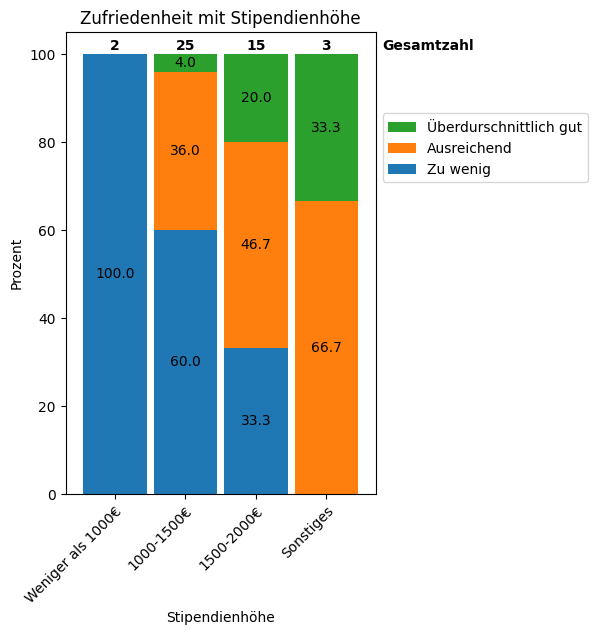

In [13]:
stacked_bar_graph(analysis_df, 
                  cols_perc=percentage_cols, 
                  title_name='Zufriedenheit mit Stipendienhöhe', 
                  ls_x_ticks=['Weniger als 1000€', '1000-1500€', '1500-2000€', 'Sonstiges'], 
                  str_x_label='Stipendienhöhe', 
                  ls_legend_levels=['Zu wenig', 'Ausreichend', 'Überdurschnittlich gut'],
                  dir_to_save='../reports/figures/stipendholders/',
                  data_name='S_001_S6_S12_Stipendienhöhe_Zufriedenheit.png',
                  figsize=(4,6))

## Förderzeitraum ausreichend?

In [14]:
ls_cols_stipend_duration = [col for col in df_stip.columns if col.startswith('S4.')]
print(ls_cols_stipend_amount)
ls_cols_duration_enough = [col for col in df_stip.columns if col.startswith('S5.')]
print(ls_cols_satisfaction)

['S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Weniger als 1.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.000–1.500 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_1.500–2.000 EUR', 'S6. Wie hoch ist Ihr monatliches Stipendium ohne Abzüge und ohne Zuschüsse?_Sonstiges']
['S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Zu wenig', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Ausreichend', 'S12. Wie schätzen Sie die Höhe des Förderbetrags (inklusive Zuschüsse, abzüglich Ausgaben für Versicherungen) ein?_Überdurchschnittlich gut']


In [15]:
print(ls_cols_stipend_duration)
order_cols = [3, 0, 1, 2, 4]
ls_cols_stipend_duration = [ls_cols_stipend_duration[i] for i in order_cols]
print(ls_cols_stipend_duration)

['S4. In welchem Zeitrahmen werden Sie gefördert?_1 Jahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre', 'S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre + 1 Jahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_6 Monate bis 1 Kalenderjahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_Sonstiges']
['S4. In welchem Zeitrahmen werden Sie gefördert?_6 Monate bis 1 Kalenderjahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_1 Jahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre', 'S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre + 1 Jahr', 'S4. In welchem Zeitrahmen werden Sie gefördert?_Sonstiges']


In [16]:
print(ls_cols_duration_enough)
order_cols = [0, 2, 1, 3]
ls_cols_duration_enough = [ls_cols_duration_enough[i] for i in order_cols]
print(ls_cols_duration_enough)

['S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Das kann ich noch nicht sagen.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Ja, in jedem Fall.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Ja, wenn nichts dazwischenkommt.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Sonstiges']
['S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Das kann ich noch nicht sagen.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Ja, wenn nichts dazwischenkommt.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Ja, in jedem Fall.', 'S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend?\xa0_Sonstiges']


In [17]:
analysis_df, percentage_cols = cross_analysis_one_hot(ls_cols_stipend_duration, ls_cols_duration_enough, df=df_stip)

In [18]:
analysis_df

,S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Das kann ich noch nicht sagen.,"S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Ja, wenn nichts dazwischenkommt.","S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Ja, in jedem Fall.",S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Sonstiges,totals,S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Das kann ich noch nicht sagen.Percentage,"S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Ja, wenn nichts dazwischenkommt.Percentage","S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _Ja, in jedem Fall.Percentage",S5. Ist der Förderzeitraum Ihrer Einschätzung nach ausreichend? _SonstigesPercentage
S4. In welchem Zeitrahmen werden Sie gefördert?_6 Monate bis 1 Kalenderjahr,0,0,0,2,2,0.000000,0.000000,0.000000,100.000000
S4. In welchem Zeitrahmen werden Sie gefördert?_1 Jahr,1,0,0,2,3,33.333333,0.000000,0.000000,66.666667
S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre,2,3,2,2,9,22.222222,33.333333,22.222222,22.222222
S4. In welchem Zeitrahmen werden Sie gefördert?_2 Jahre + 1 Jahr,2,8,0,9,19,10.526316,42.105263,0.000000,47.368421
S4. In welchem Zeitrahmen werden Sie gefördert?_Sonstiges,1,8,0,2,11,9.090909,72.727273,0.000000,18.181818


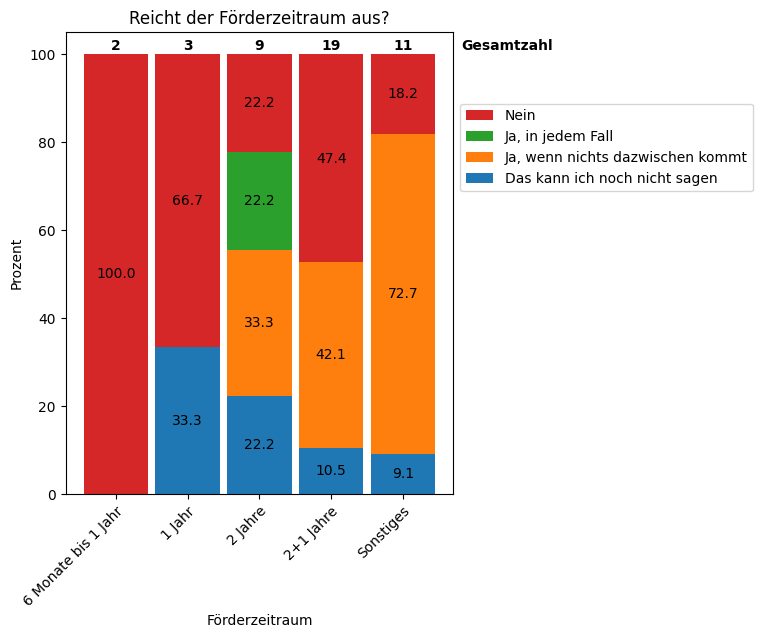

In [19]:
stacked_bar_graph(analysis_df, 
                  cols_perc=percentage_cols, 
                  title_name='Reicht der Förderzeitraum aus?', 
                  ls_x_ticks=['6 Monate bis 1 Jahr', '1 Jahr', '2 Jahre', '2+1 Jahre', 'Sonstiges'], 
                  str_x_label='Förderzeitraum', 
                  ls_legend_levels=['Das kann ich noch nicht sagen', 'Ja, wenn nichts dazwischen kommt', 'Ja, in jedem Fall', 'Nein'],
                  dir_to_save='../reports/figures/stipendholders/',
                  data_name='S_002_S4_S5_Förderzeitraum_ausreichend.png',
                  figsize=(5,6))

## Aktuelles Stipendium ist Erststipendium?

In [20]:
ls_cols_age_level = [col for col in df_stip.columns if col.endswith('.0')]
order = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 2]
ls_cols_age_level = [ls_cols_age_level[i] for i in order]
ls_decoded_age_level = ['Unter 25',
                     '25-29',
                     '30-34',
                     '35-39',
                     '40-44',
                     '45-49',
                     '50-54',
                     '55-59',
                     '60-64',
                     '65-69',
                     'Über 70']
print(ls_cols_age_level)
dict_age_level = dict(zip(ls_cols_age_level, ls_decoded_age_level))
print(dict_age_level)


['AP1. Wie alt sind Sie?_0.0', 'AP1. Wie alt sind Sie?_1.0', 'AP1. Wie alt sind Sie?_2.0', 'AP1. Wie alt sind Sie?_3.0', 'AP1. Wie alt sind Sie?_4.0', 'AP1. Wie alt sind Sie?_5.0', 'AP1. Wie alt sind Sie?_6.0', 'AP1. Wie alt sind Sie?_7.0', 'AP1. Wie alt sind Sie?_8.0', 'AP1. Wie alt sind Sie?_9.0', 'AP1. Wie alt sind Sie?_10.0']
{'AP1. Wie alt sind Sie?_0.0': 'Unter 25', 'AP1. Wie alt sind Sie?_1.0': '25-29', 'AP1. Wie alt sind Sie?_2.0': '30-34', 'AP1. Wie alt sind Sie?_3.0': '35-39', 'AP1. Wie alt sind Sie?_4.0': '40-44', 'AP1. Wie alt sind Sie?_5.0': '45-49', 'AP1. Wie alt sind Sie?_6.0': '50-54', 'AP1. Wie alt sind Sie?_7.0': '55-59', 'AP1. Wie alt sind Sie?_8.0': '60-64', 'AP1. Wie alt sind Sie?_9.0': '65-69', 'AP1. Wie alt sind Sie?_10.0': 'Über 70'}


In [21]:
dict_age_level

{'AP1. Wie alt sind Sie?_0.0': 'Unter 25',
 'AP1. Wie alt sind Sie?_1.0': '25-29',
 'AP1. Wie alt sind Sie?_2.0': '30-34',
 'AP1. Wie alt sind Sie?_3.0': '35-39',
 'AP1. Wie alt sind Sie?_4.0': '40-44',
 'AP1. Wie alt sind Sie?_5.0': '45-49',
 'AP1. Wie alt sind Sie?_6.0': '50-54',
 'AP1. Wie alt sind Sie?_7.0': '55-59',
 'AP1. Wie alt sind Sie?_8.0': '60-64',
 'AP1. Wie alt sind Sie?_9.0': '65-69',
 'AP1. Wie alt sind Sie?_10.0': 'Über 70'}

In [22]:
df_stip['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.']

0     False
1      True
2     False
3     False
4     False
5     False
6     False
7      True
8     False
9     False
10    False
11    False
12     True
13    False
14     True
15     True
16    False
17     True
18    False
19     True
20     True
21    False
22     True
23    False
24    False
25     True
26     True
27     True
28     True
29     True
30    False
31    False
32    False
33     True
34     True
35     True
36    False
37    False
38    False
39    False
40     True
41     True
42     True
43    False
44    False
Name: S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes., dtype: bool

column 'Sonstiges' should have included numerical values

In [23]:
df_stip['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges']

0      True
1     False
2      True
3      True
4      True
5      True
6      True
7     False
8      True
9      True
10     True
11     True
12    False
13     True
14    False
15    False
16     True
17    False
18     True
19    False
20    False
21     True
22    False
23     True
24     True
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33    False
34    False
35    False
36     True
37     True
38     True
39     True
40    False
41    False
42    False
43     True
44     True
Name: S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges, dtype: bool

In [24]:
df_stip_new= pd.read_csv('../data/external/Umfrage_kompletter Datensatz_1.csv')
df_stip_new.head()
df_stip_new = df_stip_new[df_stip_new['AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0'] == 'Stipendiat:in']

In [25]:
S3_old = df_stip[['id. Antwort ID', 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges', 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.']]
S3_old

,id. Antwort ID,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.
0,57,True,False
1,258,False,True
2,340,True,False
3,63,True,False
4,565,True,False
5,654,True,False
6,76,True,False
7,79,False,True
8,84,True,False
9,87,True,False


In [26]:
S3_new = df_stip_new[['id. Antwort ID', 'S3[other]. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten? [Sonstiges]']]
S3_new

,id. Antwort ID,S3[other]. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten? [Sonstiges]
2,57,2.0
18,258,NaN
21,340,2.0
33,63,2.0
34,565,2.0
42,654,4.0
43,76,4.0
45,79,NaN
48,84,3.0
51,87,8.0


In [27]:
merged_S3 = pd.merge(S3_old, S3_new, on='id. Antwort ID')
merged_S3['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges'] = merged_S3['S3[other]. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten? [Sonstiges]']
merged_S3 = merged_S3.drop('S3[other]. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten? [Sonstiges]', axis=1)
merged_S3

,id. Antwort ID,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.
0,57,2.0,False
1,258,NaN,True
2,340,2.0,False
3,63,2.0,False
4,565,2.0,False
5,654,4.0,False
6,76,4.0,False
7,79,NaN,True
8,84,3.0,False
9,87,8.0,False


In [28]:
# Replace NA values in 'numerical_column' with 1 if 'another_column' is True
merged_S3.loc[merged_S3['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.'] == True, 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges'] = merged_S3.loc[merged_S3['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.'] == True, 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges'].fillna(1)
merged_S3 = merged_S3.drop('S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Das aktuelle Stipendium ist mein erstes.', axis=1)
merged_S3


,id. Antwort ID,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges
0,57,2.0
1,258,1.0
2,340,2.0
3,63,2.0
4,565,2.0
5,654,4.0
6,76,4.0
7,79,1.0
8,84,3.0
9,87,8.0


In [29]:
df_age = df_stip[ls_cols_age_level]
df_age['id. Antwort ID'] = df_stip['id. Antwort ID']

/tmp/ipykernel_25401/1509538736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['id. Antwort ID'] = df_stip['id. Antwort ID']


In [30]:
merged_S3_age = pd.merge(merged_S3, df_age, on='id. Antwort ID')
merged_S3_age

,id. Antwort ID,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,AP1. Wie alt sind Sie?_10.0
0,57,2.0,False,False,False,False,True,False,False,False,False,False,False
1,258,1.0,False,False,True,False,False,False,False,False,False,False,False
2,340,2.0,False,False,True,False,False,False,False,False,False,False,False
3,63,2.0,False,False,True,False,False,False,False,False,False,False,False
4,565,2.0,False,False,True,False,False,False,False,False,False,False,False
5,654,4.0,False,False,True,False,False,False,False,False,False,False,False
6,76,4.0,False,False,True,False,False,False,False,False,False,False,False
7,79,1.0,False,False,False,True,False,False,False,False,False,False,False
8,84,3.0,False,False,True,False,False,False,False,False,False,False,False
9,87,8.0,False,True,False,False,False,False,False,False,False,False,False


In [31]:
df_one_hot = pd.get_dummies(merged_S3_age, columns=['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges'])
df_one_hot

,id. Antwort ID,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,AP1. Wie alt sind Sie?_10.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_1.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_2.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_3.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_4.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_6.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_8.0
0,57,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,258,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,340,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,63,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,565,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
5,654,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,76,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
7,79,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
8,84,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
9,87,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [32]:
ls_cols_stipend_amount = [col for col in df_one_hot.columns if col.startswith('S3.')]
ls_cols_stipend_amount

['S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_1.0',
 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_2.0',
 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_3.0',
 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_4.0',
 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_6.0',
 'S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_8.0']

In [33]:
analysis_df, percentage_cols = cross_analysis_one_hot(ls_cols_age_level, ls_cols_stipend_amount, df=df_one_hot)

In [34]:
analysis_df

,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_1.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_2.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_3.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_4.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_6.0,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_8.0,totals,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_1.0Percentage,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_2.0Percentage,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_3.0Percentage,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_4.0Percentage,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_6.0Percentage,S3. Wie viele Stipendien (inklusive des derzeitigen) haben Sie bereits insgesamt erhalten?_Sonstiges_8.0Percentage
AP1. Wie alt sind Sie?_0.0,1,0,0,0,0,0,1,100.000000,0.000000,0.000000,0.000000,0.000000,0.0
AP1. Wie alt sind Sie?_1.0,4,0,3,0,0,1,8,50.000000,0.000000,37.500000,0.000000,0.000000,12.5
AP1. Wie alt sind Sie?_2.0,12,7,3,3,1,0,26,46.153846,26.923077,11.538462,11.538462,3.846154,0.0
AP1. Wie alt sind Sie?_3.0,3,2,1,1,0,0,7,42.857143,28.571429,14.285714,14.285714,0.000000,0.0
AP1. Wie alt sind Sie?_4.0,0,1,1,1,0,0,3,0.000000,33.333333,33.333333,33.333333,0.000000,0.0
AP1. Wie alt sind Sie?_5.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
AP1. Wie alt sind Sie?_6.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
AP1. Wie alt sind Sie?_7.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
AP1. Wie alt sind Sie?_8.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
AP1. Wie alt sind Sie?_9.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


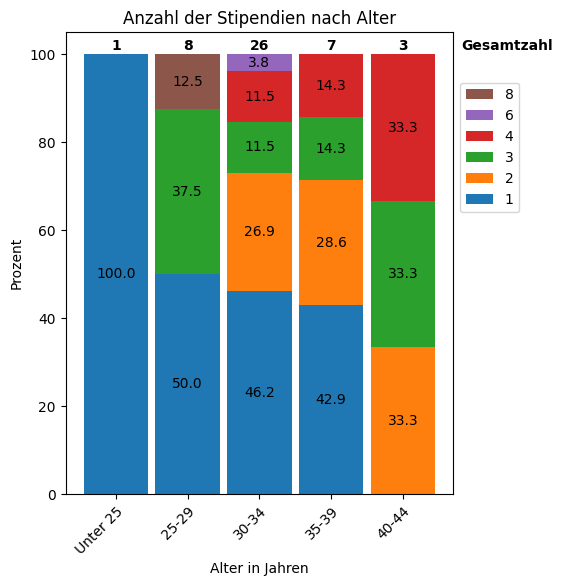

In [45]:
stacked_bar_graph(analysis_df.dropna(), 
                  cols_perc=percentage_cols, 
                  title_name='Anzahl der Stipendien nach Alter', 
                  ls_x_ticks= list(dict_age_level.values())[:len(analysis_df.dropna())], 
                  str_x_label='Alter in Jahren', 
                  ls_legend_levels=['1', '2', '3', '4', '6', '8'],
                  dir_to_save='../reports/figures/stipendholders/',
                  data_name='S_003_AP1_S3_Anzahl_Stipendien_Alter.png',
                  figsize=(5,6))